# Indonesian SMS Classification with Long Short-Term Memory (LSTM) <a class="anchor" name="chapter0"></a>

---

### Table of Contents
* [Introduction](#chapter1)
* [Conclusion / Results](#chapter2)
* [Data Preparation](#chapter3)
* [Training](#chapter4)
* [Evaluation](#chapter5)

### Introduction <a class="anchor" name="chapter1"></a>

Short message service (SMS) is a communication service in text format that has become an embedded feature on every cellphone, be it a featured phone or smartphone. Since this service has advantages such as low cost and easy to use, this is also used by certain parties to send unwanted text message, namely spam message.<br><br>
Spam is a type of message that is sent arbitrarily with various purpose such as promotions/advertising, announcements of sweepstakes and such so that they are disturbing to mobile phone users. Spam message itself has been found in many countries including Indonesia.<br>

### Data
The text dataset used in this project was obtained in two ways which is by exporting messages from many phones and the second was obtained from [here](https://drive.google.com/file/d/1-stKadfTgJLtYsHWqXhGO3nTjKVFxm_Q/view). Total data obtained are about one thousand sentence of data text. The dataset is grouped into three classes, namely normal/ham, scam/fraudulent, and promotion/advertisement text message.

### Goal
The goal of this project is to create LSTM model that can classify Indonesian text message into three categories that are mentioned above and implement it in an android texting app.

### Conclusion / Result <a class="anchor" name="chapter2"></a>

In this project, the model was able to be fitted with overall acurracy score of 0.92, F1-Score of 0.92, and ROC-AUC score of 0.94. The result of each class are presented below:

|Class|Recall|Precision|F1-Score|ROC-AUC|
|:---:|:---:|:---:|:---:|:---:|
|Normal|0.92|0.99|0.95|0.97|
|Scam|0.94|0.85|0.89|0.91|
|Promotion|0.88|0.92|0.90 |0.94|
|**Average**|**0.92**|**0.92**|**0.92**|**0.94**|

[Back to Table of Contents](#chapter0)

# Data Preparation <a class="anchor" name="chapter3"></a>

Import library

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, SpatialDropout1D

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

Load dataset, shuffle it, and see first five data.

In [ ]:
file_name = "/content/drive/MyDrive/data_lengkap.csv"
df = pd.read_csv(file_name, sep=",", header=0)
df = df.sample(frac=1)
df.head(5)

,Teks,label
183,"RAWIT harganya miring, Internetan makin sering...",2
888,Ada internet min alamatnya dmn?,0
1252,Oh udah yah haha aku bingung jd gimana udh ket...,0
320,Tingkatkan nilai isi ulang Anda selanjutnya mi...,2
1369,tapi kuliahnya sekarang. SP sebenarnya tidak b...,0


Show dataset info.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1469 entries, 183 to 1214
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Teks    1469 non-null   object
 1   label   1469 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 34.4+ KB


In [ ]:
df.shape

(1469, 2)

Count each label value.

In [ ]:
df.label.value_counts()

0    598
1    537
2    334
Name: label, dtype: int64

Show the percentage of each class.

In [ ]:
df.label.value_counts(normalize=True)

0    0.407080
1    0.365555
2    0.227366
Name: label, dtype: float64

Check if there is missing value.

In [ ]:
df.isna().any()

Teks     False
label    False
dtype: bool

Check for duplicated rows.

In [ ]:
df[df.duplicated()].shape

(32, 2)

Drop duplicated rows and show data shape.

In [ ]:
df.drop_duplicates(inplace=True, keep="first")
df.shape

(1437, 2)

Visualize count of each label

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


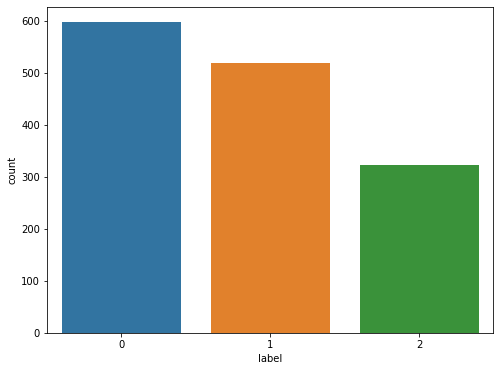

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(df.label)

After knowing that we are working with unbalanced dataset, when evaluating the model later it is better to use metrics like F1 score and/or ROC-AUC.

Import `nltk` library in order to use their Indonesian stopwords list.

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

We are also using stopwords list from `pysastrawi` library and combine it with `nltk` stopwords list.

In [ ]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

factory = StopWordRemoverFactory()
STOPWORDS_2 = factory.create_stop_word_remover()

Create a function to remove punctionation and stopwords, convert text to lowercase, etc.

In [ ]:
import re
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('indonesian'))
STOPWORDS = STOPWORDS.union(STOPWORDS_2.dictionary.words)

def clean_text(text):
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    return text

Apply `clean_text` function to preprocess data. Also here we remove any numeric from the data.

In [ ]:
df["Teks"] = df["Teks"].apply(clean_text)
df["Teks"] = df["Teks"].str.replace("\d+", "")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


Bellow we generate histogram to see each sentence word lengths distribution.

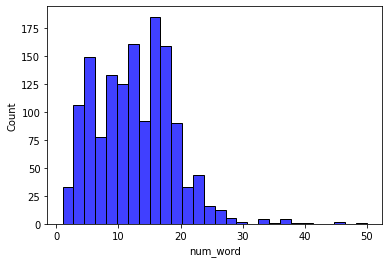

In [ ]:
text = df.copy()
text["num_word"] = text["Teks"].apply(lambda x: len(str(x).split()))
sns.histplot(data=text, x="num_word", color="blue")

Create a separate variable for all data from each class.

In [ ]:
ham_sms = df[df.label == 0]
scam_sms = df[df.label == 1]
promo_sms = df[df.label == 2]

Create a function to generate wordcloud.

In [ ]:
def show_wordcloud(data):
  wordcloud = WordCloud(width=520, 
                              height=260, 
                              max_font_size=100, 
                              background_color="black").generate(data)
  plt.figure(figsize=(16, 10))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()

**Generate wordcloud for ham/normal text message.**

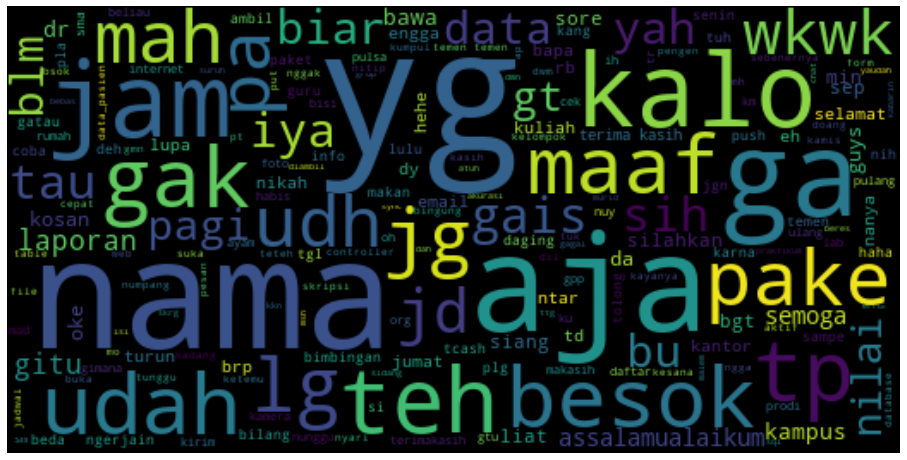

In [ ]:
ham_sms_text = " ".join(ham_sms["Teks"].tolist())
show_wordcloud(ham_sms_text)

The most common word for ham/normal text message is **'nama'** (name), **'maaf'** (sorry), etc.

**Generate wordlcoud for scam/fraudulent text message.**

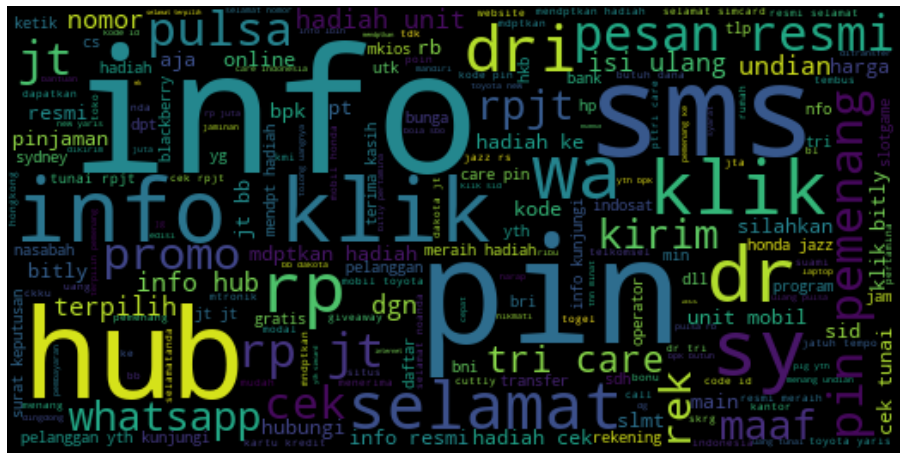

In [ ]:
scam_sms_text = " ".join(scam_sms["Teks"].tolist())
show_wordcloud(scam_sms_text)

For scam/fraudulent class, the most common word is **'info'**, **'pin'**, **'hub'** (call), etc

**Generate wordcloud for promotion/advertisement text message.**

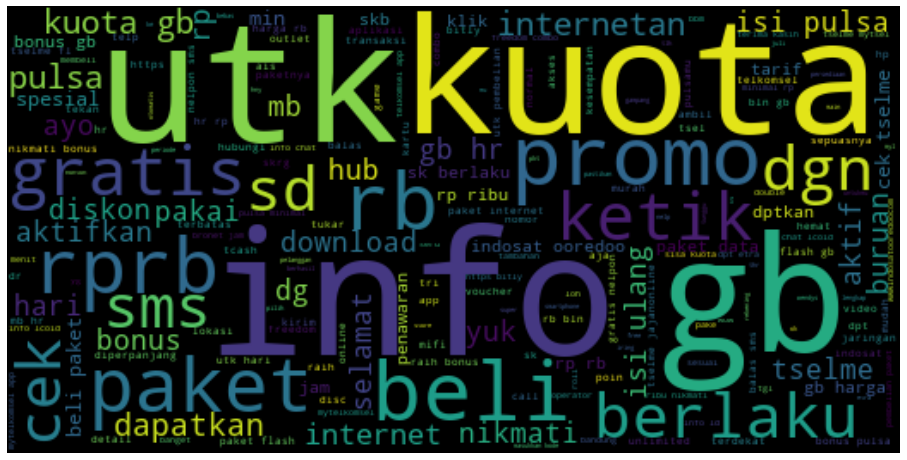

In [ ]:
promo_sms_text = " ".join(promo_sms["Teks"].tolist())
show_wordcloud(promo_sms_text)

As for promotion/advertisement text message, **'kuota'** (quota), **'info'**, etc. is the most common words.

Next we split dataset into two parts, the text message and the label.

In [ ]:
data = df["Teks"].values
label = df["label"].values

Since we are doing a multiclass classification, we are going to convert the labels using `get_dummies` function from `pandas` to perform one-hot encoding technique.

In [ ]:
label = pd.get_dummies(label)

Split the dataset into train set and test set with ratio of 75%:25%.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data,
                                                    label,
                                                    test_size = 0.25,
                                                    random_state=42)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1077,) (1077, 3)
(360,) (360, 3)


Find the average number of tokens (words) in the training data. This value will be used later to match the sequence each number.

In [ ]:
round(sum([len(i.split()) for i in x_train])/len(x_train))

13

Create a tokenizer and fit it with training set.

In [ ]:
MAX_NB_WORDS = 8000
MAX_SEQUENCE_LEN = 13
EMBEDDING_DIM = 128

tokenizer = Tokenizer(num_words=MAX_NB_WORDS,
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', 
                      lower=True)

tokenizer.fit_on_texts(x_train)
word_idx = tokenizer.word_index
print(f"{len(word_idx)} words token")

4087 words token


There are 4087 words in the vocabulary created by tokenizer.

Next we convert text data into numeric sequences and limit each sentences into 13 sequence lengths. If there are data that is less than 13 sequences, it will be filled with zero. Meanwhile, data that has more than 13 sequences will be trimmed into 13 sequence.

In [ ]:
x_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(x_train, maxlen=MAX_SEQUENCE_LEN)
x_train.shape[1]

13

[Back to Table of Contents](#chapter0)

# Training <a class="anchor" name="chapter4"></a>
---

The model consists of:
1. `Embedding` layer as input layer.
2. To reduce co-dependency, we are also using 1D spatial dropout with dropout rate = 0.7 
3. `LSTM` layer as first hidden layer with 100 units, dropout rate 0.7, and recurrent dropout rate 0.7.
4. `Dense` layer as second hidden layer with 128 units and `relu` activation function. By adding a dense layer will improve accuracy.
5. `Dropout` layer with dropout rate 0.2.
6. `Dense` layer with 3 units and `softmax` activation function as output layer.


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=x_train.shape[1], mask_zero=True))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(100, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation="softmax"))

model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 13, 128)           1024000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 13, 128)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               91600     
                                                                 
 dense (Dense)               (None, 128)               12928     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                        

Set the max epochs to 50, batch size to 128 and create an `EarlyStopping` callback to stop the training process when a monitored metric has stopped improving (this will also prevent model from overfitting).<br>
We also split the training set of each epoch to use 10% of it as validation set.

In [ ]:
epochs = 50
batch_size = 128
early_stop = EarlyStopping(monitor="val_loss", patience=3, min_delta=0.0001)

history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[early_stop])

Epoch 1/50
8/8 [==============================] - 12s 435ms/step - loss: 1.0973 - accuracy: 0.3695 - val_loss: 1.0911 - val_accuracy: 0.5000
Epoch 2/50
8/8 [==============================] - 1s 175ms/step - loss: 1.0807 - accuracy: 0.4830 - val_loss: 1.0802 - val_accuracy: 0.6481
Epoch 3/50
8/8 [==============================] - 1s 187ms/step - loss: 1.0565 - accuracy: 0.5439 - val_loss: 1.0539 - val_accuracy: 0.5185
Epoch 4/50
8/8 [==============================] - 2s 230ms/step - loss: 0.9979 - accuracy: 0.5459 - val_loss: 0.9767 - val_accuracy: 0.5370
Epoch 5/50
8/8 [==============================] - 1s 160ms/step - loss: 0.8618 - accuracy: 0.6533 - val_loss: 0.7938 - val_accuracy: 0.6759
Epoch 6/50
8/8 [==============================] - 1s 162ms/step - loss: 0.7054 - accuracy: 0.7224 - val_loss: 0.6698 - val_accuracy: 0.6574
Epoch 7/50
8/8 [==============================] - 1s 187ms/step - loss: 0.5458 - accuracy: 0.8225 - val_loss: 0.4995 - val_accuracy: 0.8611
Epoch 8/50
8/8 [===

As we can see from the above results, by using `EarlyStopping` callback the training process only lasts for 14 out of 50 epochs because loss and accuracy is no longer improving.

[Back to Table of Content](#chapter0)

# Evaluation <a class="anchor" name="chapter5"></a>
---

Convert test set into a numeric sequences and adjust the sequence length with `pad_sequence`.

In [ ]:
x_test = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(x_test, maxlen=MAX_SEQUENCE_LEN)

Evaluate model using test set and show model loss and accuracy.

In [ ]:
accr = model.evaluate(x_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

12/12 [==============================] - 0s 8ms/step - loss: 0.2387 - accuracy: 0.9278
Test set
  Loss: 0.239
  Accuracy: 0.928


Plot graph to compare the loss to the increase number of epochs on the training and validation set.

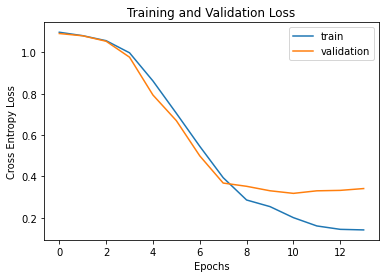

In [ ]:
plt.title('Training and Validation Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.show();

It can be seen that there is a decrease in the value of loss/error when the number of epochs increases.

We also plot graph of the comparison of accuracy to the increase in the number of epoch from training and validation set.

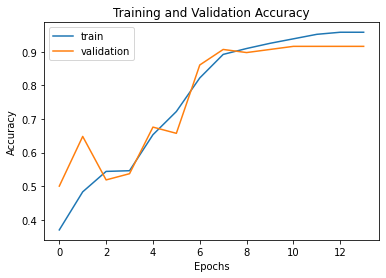

In [ ]:
plt.title('Training and Validation Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show();

The above graph show that there is an increase in the value of accuracy as the number of epochs increases. Accuracy and loss graph show that model is not overfitted by looking at the validation set line.

Prepare the actual label and predicted label, convert it back to it's normal label (0, 1, 2) from one-hot encoding format. 

In [ ]:
y_test = np.argmax(y_test.to_numpy(), axis=1)

model_pred_prob = model.predict(x_test)
model_pred_prob = tf.squeeze(tf.round(model_pred_prob))
y_pred = np.argmax(model_pred_prob, axis=1)

Create a functin to calculate average `accuracy`, `precision`, `recall`, and `F1 score`.

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, multilabel_confusion_matrix, classification_report, ConfusionMatrixDisplay, confusion_matrix,  roc_curve, auc, roc_auc_score

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

Calculate the average accuracy, precision, recall, and F1 score.

In [ ]:
test_results = calculate_results(y_test, y_pred)
test_results

{'accuracy': 91.94444444444444,
 'f1': 0.9155769568819553,
 'precision': 0.9157988375437259,
 'recall': 0.9178099984706694}

Show each class true positive, false positive, true negative, false negative, precision, recall, and f1-score value.

In [ ]:
cm = multilabel_confusion_matrix(y_test, y_pred)
all_tp = []
all_fp = []
all_tn = []
all_fn = []
for i in range(len(cm)):
  all_tp.append(cm[i][1][1])
  all_fp.append(cm[i][0][1])
  all_tn.append(cm[i][0][0])
  all_fn.append(cm[i][1][0])

for h, (i, j, k, l) in enumerate(zip(all_tp, all_fp, all_tn, all_fn)):
  if h == 0:
    print(f"Normal: TP = {i}, FP = {j}, TN = {k}, FN = {l}")
  elif h == 1:
    print(f"Scam: TP = {i}, FP = {j}, TN = {k}, FN = {l}")
  elif h == 2:
    print(f"Promo: TP = {i}, FP = {j}, TN = {k}, FN = {l}")

print(classification_report(y_test, y_pred))

Normal: TP = 140, FP = 12, TN = 206, FN = 2
Scam: TP = 115, FP = 7, TN = 218, FN = 20
Promo: TP = 76, FP = 10, TN = 267, FN = 7
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       142
           1       0.94      0.85      0.89       135
           2       0.88      0.92      0.90        83

    accuracy                           0.92       360
   macro avg       0.92      0.92      0.92       360
weighted avg       0.92      0.92      0.92       360



Visualize the TP, FP, TN, and FN in form of confusion matrix.

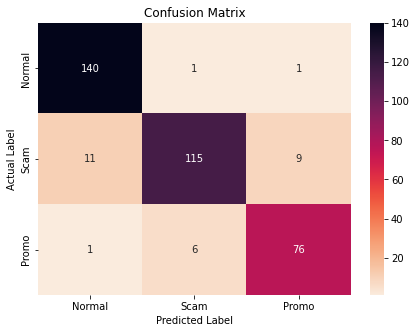

In [ ]:
cm2 = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm2,
                     index = ['Normal','Scam','Promo'], 
                     columns = ['Normal','Scam','Promo'])

plt.figure(figsize=(7,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap="rocket_r")
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

Create a function to calculate ROC-AUC score and then plot the ROC Curve.

[0.         0.05504587 1.        ] [0.         0.98591549 1.        ] [2 1 0]
[0.         0.03111111 1.        ] [0.         0.85185185 1.        ] [2 1 0]
[0.         0.03610108 1.        ] [0.         0.91566265 1.        ] [2 1 0]
ROC AUC score: 0.9385286549514622


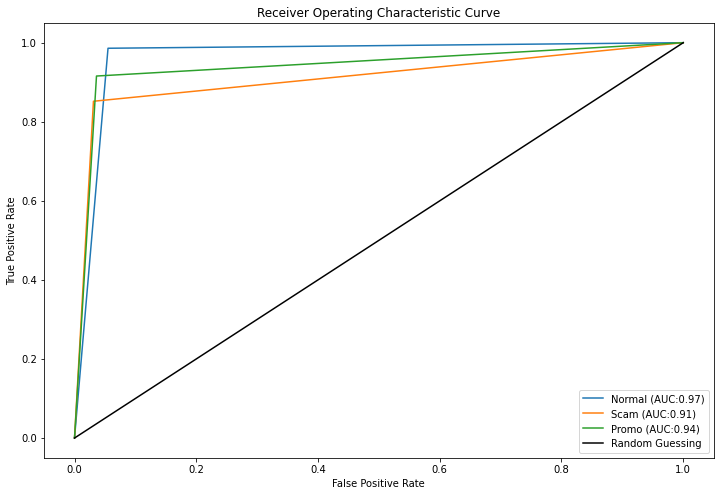

In [ ]:
from sklearn.preprocessing import LabelBinarizer

target= cm_df.columns

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
        print(fpr, tpr, thresholds)
    c_ax.plot(fpr, fpr, 'k-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_test, y_pred))

c_ax.set_title("Receiver Operating Characteristic Curve")
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

The overall model ROC-AUC score is about 0.938. From ROC Curve we can see that each class has ROC-AUC above 0.9 so the model can predict new data pretty well.

[Back to Table of Contents](#chapter0)

# Save Model, Stopwords and Vocabulary
---

Save the list of stopwords into `json` file.

In [ ]:
import json

stopw = {}
for i, j in enumerate(STOPWORDS):
  stopw[j] = i

with open('/content/drive/MyDrive/models/stopwords.json', 'w') as f:
    json.dump(stopw, f)

Save the vocabulary created by `tokenizer` into `json` file.

In [ ]:
with open ("/content/drive/MyDrive/models/words.json", "w") as file:
  json.dump(tokenizer.word_index, file)

Save model then convert it into `tflite` format so it can be used on smaller device like raspberry-pi or android.

In [ ]:
model.save('/content/drive/MyDrive/models/model.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()
open("/content/drive/MyDrive/models/model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpauqsbd1g/assets


4903916

[Back to Table of Contents](#chapter0)